In [1]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [2]:
# установка подходящей версии torch

from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
print(torch.version.cuda)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

10.1
CUDA is available!  Training on GPU ...


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/My\ Drive/my_dataset.zip -d task

In [6]:
!ls train

ls: cannot access 'train': No such file or directory


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 13 20:30:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [12]:
class CoinsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomVerticalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
TRAIN_DIR = Path('task/my_dataset/train')
print(TRAIN_DIR)
TEST_DIR = Path('task/my_dataset/test')

train_val_files = list(TRAIN_DIR.rglob('*.jpg')) 
print(train_val_files)
print(list(TEST_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(test_files)

task/my_dataset/train
[PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477281240.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477195476.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477194780.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477195512.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477280556.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477280058.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477195464.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477280994.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477280520.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477280550.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477280682.jpg'), PosixPath('task/my_dataset/train/100 coin,Brazilian Coin/100_1477195050.jpg'), PosixPath('task/my_dataset/tr

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [15]:
val_dataset = CoinsDataset(val_files, mode='val')

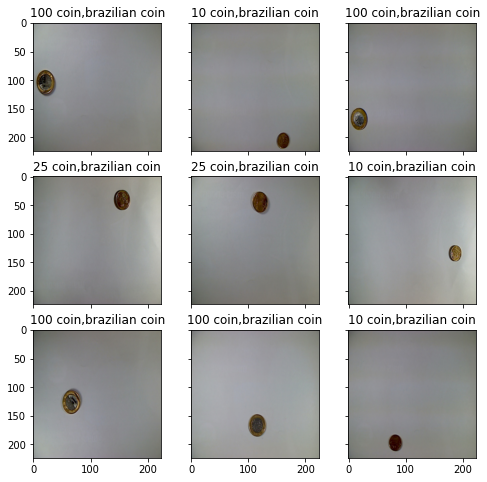

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,300))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
          title=img_label,plt_ax=fig_x)

In [18]:
import torchvision.models as models

In [21]:
model_1 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_1.parameters():
    param.requires_grad = False
for param in model_1.layer4.parameters():
    param.requires_grad = True

model_1.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 5)
)

In [22]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    if scheduler is not None:
        scheduler.step()
    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
    

In [24]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import AdamW

In [28]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = AdamW(model.parameters(), lr=0.0005)
        scheduler = ExponentialLR(optimizer=opt, gamma=0.85)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [29]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [30]:
n_classes = len(np.unique(train_val_labels))
my_cnn_1 = model_1.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_cnn_1)

we will classify :5
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

In [31]:
if val_dataset is None:
    val_dataset = CoinsDataset(val_files, mode='val')
    
train_dataset = CoinsDataset(train_files, mode='train')

In [32]:
history = train(train_dataset, val_dataset, model=my_cnn_1, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5190126493565077


epoch:  10%|█         | 1/10 [00:36<05:31, 36.82s/it]


Epoch 001 train_loss: 0.5190     val_loss 1.4533 train_acc 0.8214 val_acc 0.6313
loss 0.5670374910355782


epoch:  20%|██        | 2/10 [01:12<04:52, 36.58s/it]


Epoch 002 train_loss: 0.5670     val_loss 0.2683 train_acc 0.8057 val_acc 0.9184
loss 0.19041213001417087


epoch:  30%|███       | 3/10 [01:49<04:15, 36.53s/it]


Epoch 003 train_loss: 0.1904     val_loss 0.1659 train_acc 0.9407 val_acc 0.9478
loss 0.13946294306767784


epoch:  40%|████      | 4/10 [02:25<03:39, 36.57s/it]


Epoch 004 train_loss: 0.1395     val_loss 0.1660 train_acc 0.9603 val_acc 0.9527
loss 0.0773317388577765


epoch:  50%|█████     | 5/10 [03:02<03:03, 36.63s/it]


Epoch 005 train_loss: 0.0773     val_loss 0.2088 train_acc 0.9755 val_acc 0.9494
loss 0.06713617640503347


epoch:  60%|██████    | 6/10 [03:39<02:26, 36.56s/it]


Epoch 006 train_loss: 0.0671     val_loss 0.1537 train_acc 0.9771 val_acc 0.9592
loss 0.059015465142873556


epoch:  70%|███████   | 7/10 [04:15<01:49, 36.56s/it]


Epoch 007 train_loss: 0.0590     val_loss 0.1670 train_acc 0.9804 val_acc 0.9413
loss 0.03940045345264345


epoch:  80%|████████  | 8/10 [04:52<01:13, 36.52s/it]


Epoch 008 train_loss: 0.0394     val_loss 0.0888 train_acc 0.9864 val_acc 0.9723
loss 0.02407351319569634


epoch:  90%|█████████ | 9/10 [05:29<00:36, 36.67s/it]


Epoch 009 train_loss: 0.0241     val_loss 0.0905 train_acc 0.9924 val_acc 0.9723
loss 0.01792110448206836


epoch: 100%|██████████| 10/10 [06:05<00:00, 36.57s/it]


Epoch 010 train_loss: 0.0179     val_loss 0.1054 train_acc 0.9956 val_acc 0.9690


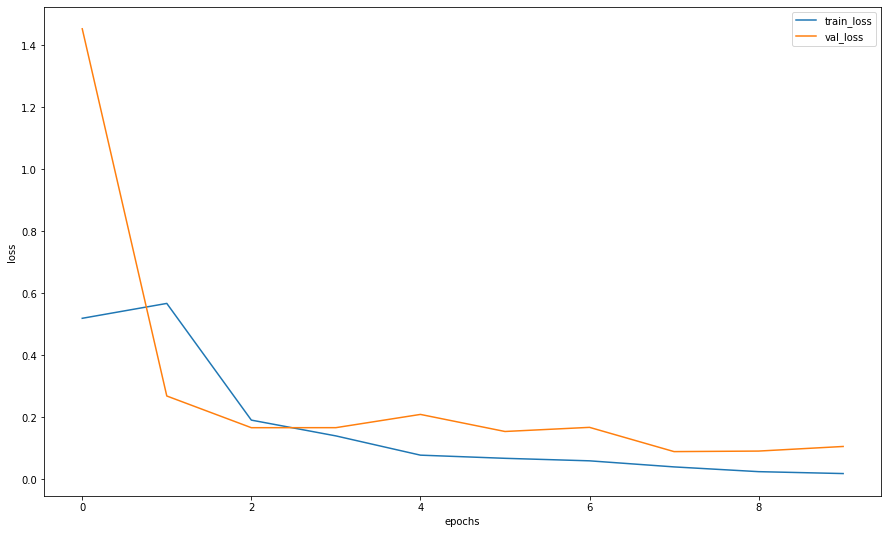

In [33]:
plt.figure(figsize=(15, 9))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

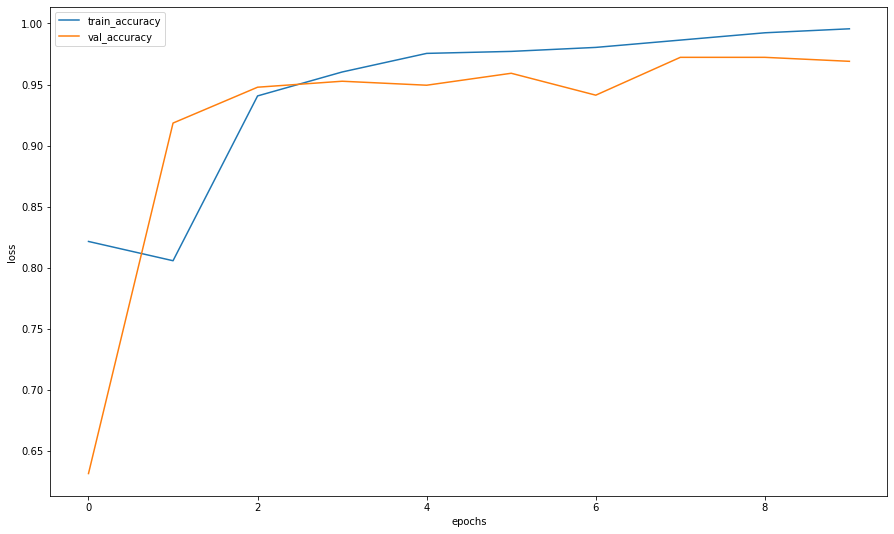

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
# предсказание для одной картинки
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
random_coins = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn_1, ex_img.unsqueeze(0))
print(probs_im)

[[8.8591409e-01 2.4004376e-07 3.6379495e-06 1.1407251e-01 9.6295043e-06]]


In [38]:
idxs = list(map(int, np.random.uniform(0,200, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn_1, imgs)
print(probs_ims)

[[9.99999642e-01 3.54377674e-16 1.16390349e-10 3.62551077e-07
  5.85242888e-15]
 [5.61574757e-01 6.22904599e-06 4.31310177e-01 7.09755812e-03
  1.12381567e-05]
 [1.00000000e+00 2.46418975e-30 7.76837544e-21 2.44698597e-12
  2.36834571e-27]
 [9.99443233e-01 1.88300509e-09 1.07610583e-06 5.55641891e-04
  2.18626344e-08]
 [3.76038079e-04 9.81698990e-01 1.73955541e-02 4.95187996e-04
  3.42374624e-05]
 [1.00000000e+00 2.76623828e-19 4.04094184e-13 3.31968799e-08
  1.18391871e-17]
 [9.99997258e-01 3.99760012e-14 4.29715330e-09 2.78416928e-06
  6.11935578e-13]
 [1.00000000e+00 1.54140882e-31 1.02656204e-21 8.22920941e-13
  1.63672893e-28]
 [4.61620743e-07 9.99891043e-01 1.08283210e-04 2.60063899e-07
  1.45650036e-09]
 [9.99986768e-01 1.01840459e-13 9.74428316e-10 1.31870711e-05
  3.06354096e-12]
 [1.00000000e+00 4.23246541e-20 7.64366326e-14 2.57887471e-08
  3.98303554e-18]
 [7.80573697e-04 9.74456728e-01 2.27379370e-02 1.77586102e-03
  2.48884375e-04]
 [2.84911650e-08 9.99987364e-01 1.258364

In [39]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [40]:
y_pred = np.argmax(probs_ims,-1)
print(y_pred)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
print(preds_class)
print(actual_labels)

[0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 3]
['10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '100 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '100 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '100 coin,Brazilian Coin', '100 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '10 coin,Brazilian Coin', '100 coin,Brazilian Coin', '5 Coin,Brazilian Coin']
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]


In [41]:
all_labels = np.unique(train_val_labels)
n_classes = len(all_labels)

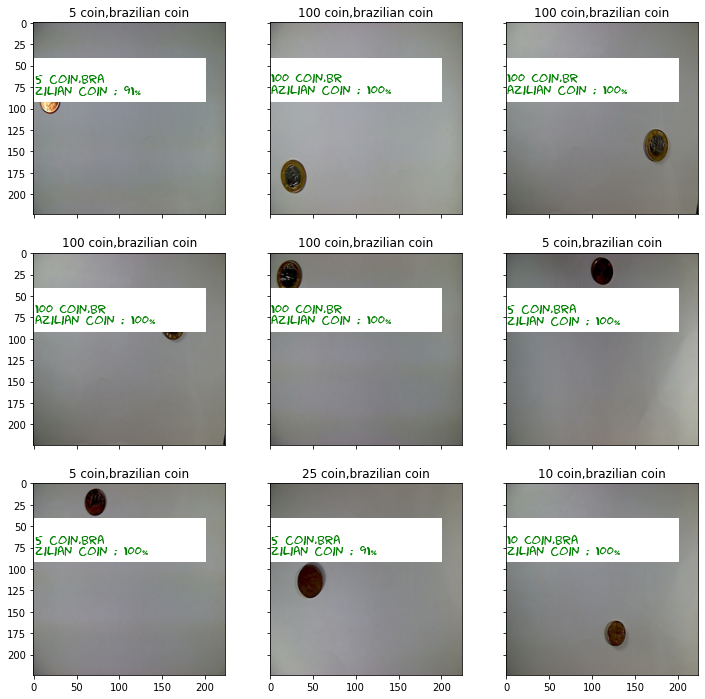

In [52]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 41),200,50,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn_1, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=13, color='green',fontweight='bold')